In [311]:
import numpy as np
import pandas as pd
from minisom import MiniSom
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
import copy
import joblib

In [324]:
# Load the dataset from the CSV file
file_path = r'D:\UOM\FYP\Data_gaiya\RAW data\csv\Base Hospital Mahiyanganaya GGU.csv'
df = pd.read_csv(file_path, skiprows=1, header=1)
df['Time'] = pd.to_datetime(df['Time'], format='%m.%d.%Y %H:%M:%S')

# Create a new DataFrame with the selected columns
selected_columns = ['Time','Power(W)','Temperature(℃)']
df = df[selected_columns]

df_new = copy.deepcopy(df)
df_new['Time'] = pd.to_datetime(df_new['Time'], format='%m.%d.%Y %H:%M:%S')

# df['Time'] = round((df['Time'].astype(np.int64) / 10**18),10)

# Extract datetime components
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['day'] = df['Time'].dt.day
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second

df = df.drop(columns=['Time','year','second','month','day'])


df.isna().sum()
df_new.isna().sum()
df.dropna()
df_new.dropna()
print(df.shape)
print(df_new.shape)

print(df_new.head(10))
print(df.head(30))




(18568, 4)
(18568, 3)
                 Time  Power(W)  Temperature(℃)
0 2023-11-16 05:55:39         0            20.9
1 2023-11-16 05:58:39         0            22.0
2 2023-11-16 06:00:14         0            22.4
3 2023-11-16 06:01:20         0            22.8
4 2023-11-16 06:02:21         0            23.2
5 2023-11-16 06:03:23        27            23.6
6 2023-11-16 06:04:24        30            23.8
7 2023-11-16 06:05:25        32            24.1
8 2023-11-16 06:06:26        39            24.3
9 2023-11-16 06:07:27        60            24.6
    Power(W)  Temperature(℃)  hour  minute
0          0            20.9     5      55
1          0            22.0     5      58
2          0            22.4     6       0
3          0            22.8     6       1
4          0            23.2     6       2
5         27            23.6     6       3
6         30            23.8     6       4
7         32            24.1     6       5
8         39            24.3     6       6
9         60        

In [325]:
# Normalize the data
scaler1 = StandardScaler()
df_scaled = scaler1.fit_transform(df.values)

# Save the scaler to a file
joblib.dump(scaler1, 'scaler.joblib')

print(df_scaled)

[[-0.97983227 -3.52114638 -1.85093135  1.4714155 ]
 [-0.97983227 -3.32445558 -1.85093135  1.6437418 ]
 [-0.97983227 -3.25293166 -1.56721172 -1.68789995]
 ...
 [-0.97983227  0.60936031  1.8374238  -0.99859476]
 [-0.97971637  0.62724129  1.8374238  -0.94115266]
 [-0.97960046  0.62724129  1.8374238  -0.88371056]]


In [326]:
# Create a SOM grid
som = MiniSom(4, 4, df_scaled.shape[1], sigma=1, learning_rate=0.1)


In [327]:
# Train the SOM on the data
som.train_random(df_scaled, 3000)  # Train for 1000 iterations


In [328]:
# Calculate quantization error
qe = som.quantization_error(df_scaled)
print("Quantization Error:", qe)

# Calculate topographic error
te = som.topographic_error(df_scaled)
print("Topographic Error:", te)

Quantization Error: 0.6996819441662002
Topographic Error: 0.09220163722533391


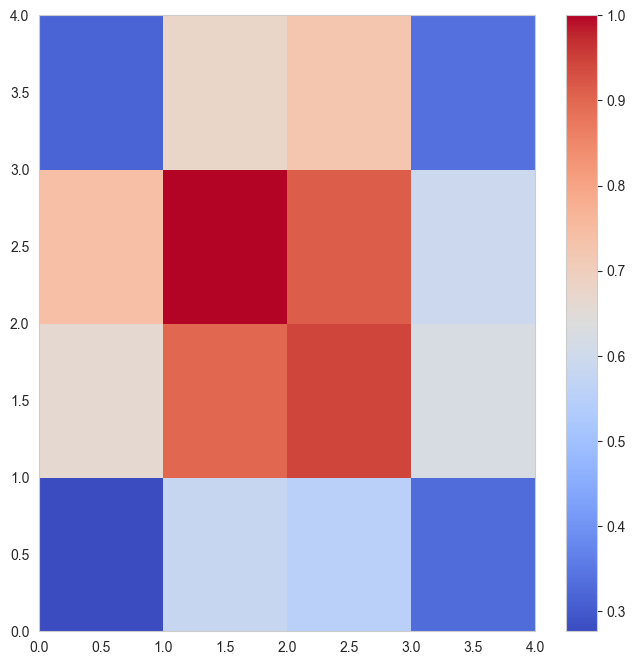

In [329]:
# Visualize the SOM
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm')  # Display a heatmap of the SOM's weights
plt.colorbar()
plt.show()

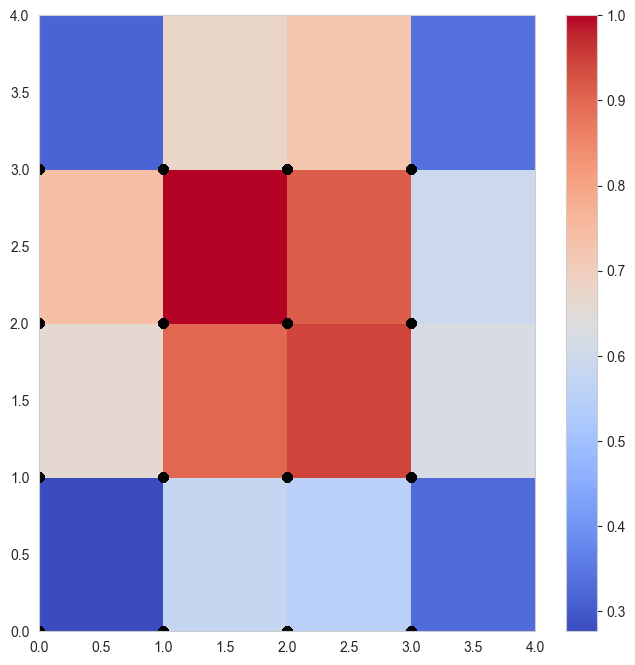

In [330]:
# Map the data onto the trained SOM
mapped_data = np.array([som.winner(d) for d in df_scaled])

# Overlay the original data points onto the visualization
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.scatter(mapped_data[:, 0], mapped_data[:, 1], c='black', marker='o')
plt.show()

In [331]:
# Assign cluster labels based on SOM grid coordinates
cluster_labels = np.zeros(len(df), dtype=int)
unique_coords, cluster_indices = np.unique(mapped_data, axis=0, return_inverse=True)
cluster_labels = cluster_indices

print(cluster_indices)

[ 3  3  2 ... 15 15 15]


In [333]:
# Calculate silhouette score
silhouette = silhouette_score(df_scaled, cluster_indices)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.2742964057033744


In [334]:
# Print the labeled data
for i in range(len(df_scaled)):
    print(f"Data point {df_scaled[i]} belongs to cluster {cluster_labels[i]}")


Data point [-0.97983227 -3.52114638 -1.85093135  1.4714155 ] belongs to cluster 3
Data point [-0.97983227 -3.32445558 -1.85093135  1.6437418 ] belongs to cluster 3
Data point [-0.97983227 -3.25293166 -1.56721172 -1.68789995] belongs to cluster 2
Data point [-0.97983227 -3.18140773 -1.56721172 -1.63045785] belongs to cluster 2
Data point [-0.97983227 -3.10988381 -1.56721172 -1.57301575] belongs to cluster 2
Data point [-0.97670273 -3.03835988 -1.56721172 -1.51557365] belongs to cluster 2
Data point [-0.97635501 -3.00259792 -1.56721172 -1.45813155] belongs to cluster 2
Data point [-0.97612319 -2.94895497 -1.56721172 -1.40068945] belongs to cluster 2
Data point [-0.97531182 -2.91319301 -1.56721172 -1.34324735] belongs to cluster 2
Data point [-0.97287774 -2.85955007 -1.56721172 -1.28580525] belongs to cluster 2
Data point [-0.97357319 -2.82378811 -1.56721172 -1.22836315] belongs to cluster 2
Data point [-0.97461637 -2.77014516 -1.56721172 -1.17092105] belongs to cluster 2
Data point [-0.9

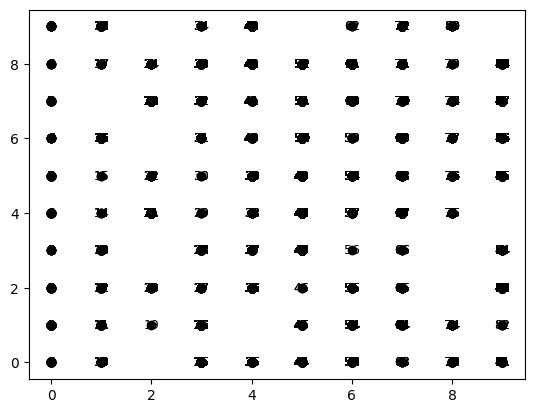

In [78]:
for i, winner in enumerate(mapped_data):
    plt.text(winner[0], winner[1], str(cluster_labels[i]), ha='center', va='center', fontsize=9)

plt.scatter(mapped_data[:, 0], mapped_data[:, 1], c='black', marker='o')
plt.show()

In [335]:
# Assign cluster labels based on SOM grid coordinates
mapped_data = np.array([som.winner(x) for x in df_scaled])
cluster_labels = np.ravel_multi_index(mapped_data.T, (4, 4))  # Convert coordinates to cluster labels

# Add a new column to the original data frame with cluster labels
df_new['Cluster_Labels'] = cluster_labels

# Add a new column to the original data frame with cluster labels
df_new['Cluster_Labels'] = cluster_labels

# Now df contains the original data along with the assigned cluster labels
print(df_new.head(500))

                   Time  Power(W)  Temperature(℃)  Cluster_Labels
0   2023-11-16 05:55:39         0            20.9               3
1   2023-11-16 05:58:39         0            22.0               3
2   2023-11-16 06:00:14         0            22.4               2
3   2023-11-16 06:01:20         0            22.8               2
4   2023-11-16 06:02:21         0            23.2               2
..                  ...       ...             ...             ...
495 2023-11-16 14:37:26      6547            40.5              10
496 2023-11-16 14:38:28      6350            40.5              10
497 2023-11-16 14:39:30      6015            40.5              10
498 2023-11-16 14:40:34      5724            40.5              10
499 2023-11-16 14:45:41      5459            40.7              10

[500 rows x 4 columns]


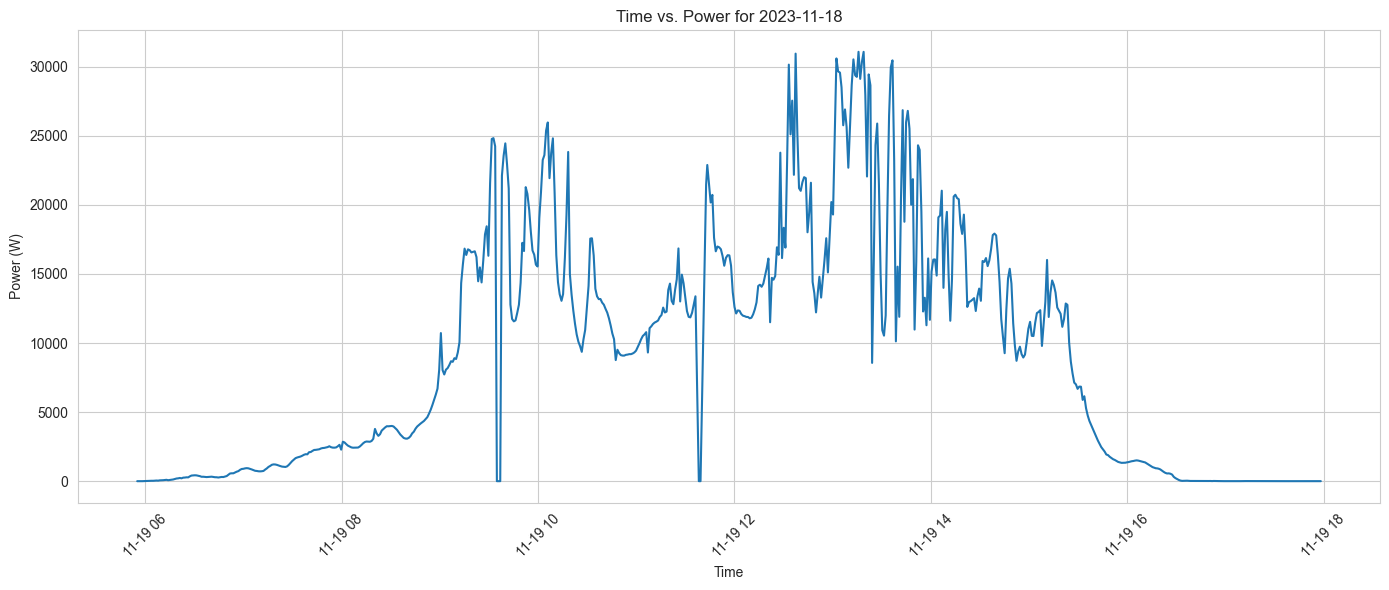

In [336]:
import matplotlib.pyplot as plt

# Assuming 'Time' column is already in datetime format
specific_date = '2023-11-19'

# Filter data for a specific date, for example, '2023-11-16'
specific_date_data = df_new[df_new['Time'].dt.date == pd.to_datetime(specific_date).date()]

# Plot time vs power
plt.figure(figsize=(14, 6))
plt.plot(specific_date_data['Time'], specific_date_data['Power(W)'])

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.title("Time vs. Power for 2023-11-18")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


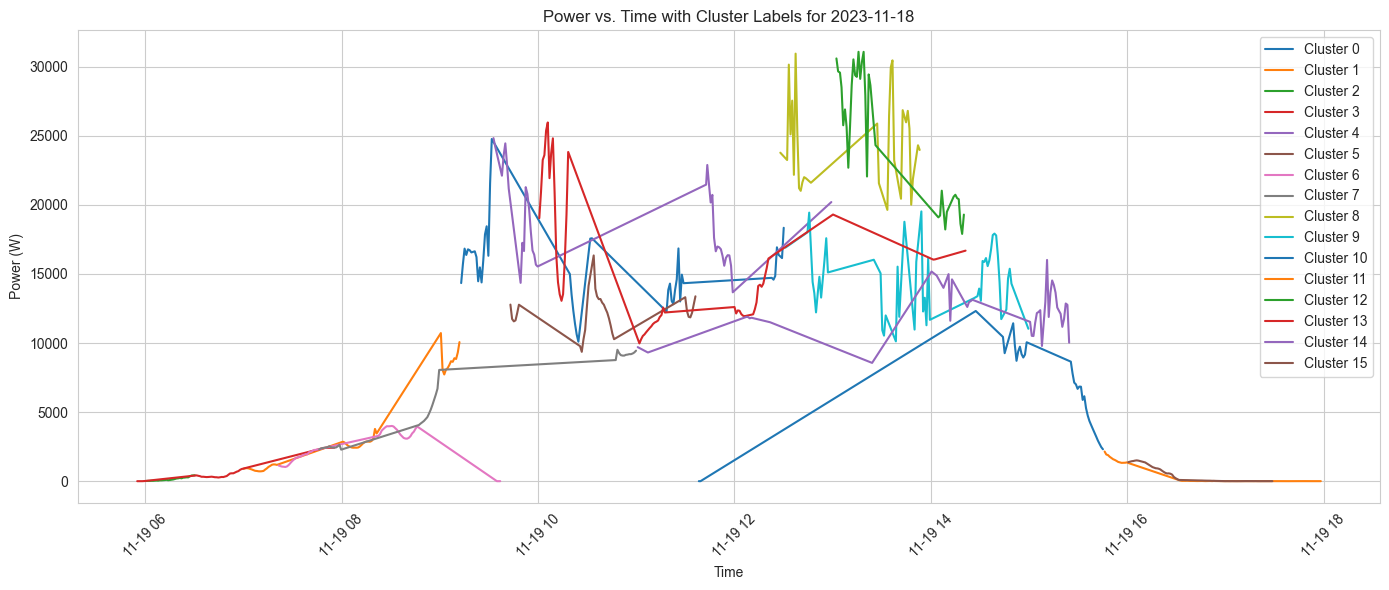

In [337]:
import matplotlib.pyplot as plt

# Assuming 'Time' column is already in datetime format
specific_date = '2023-11-19'

# Filter data for a specific date, for example, '2023-11-16'
specific_date_data = df_new[df_new['Time'].dt.date == pd.to_datetime(specific_date).date()]

# Create an empty DataFrame to store all cluster data
combined_data = pd.DataFrame(columns=['Time', 'Power(W)', 'Cluster_Labels'])

# Concatenate all cluster data into a single DataFrame
for cluster_label, cluster_data in specific_date_data.groupby('Cluster_Labels'):
    combined_data = pd.concat([combined_data, cluster_data[['Time', 'Power(W)', 'Cluster_Labels']]], ignore_index=True)

# Plot all clusters on one line chart
plt.figure(figsize=(14, 6))

# Group combined data by cluster label and plot each cluster separately with different colors
for cluster_label, cluster_data in combined_data.groupby('Cluster_Labels'):
    plt.plot(cluster_data['Time'], cluster_data['Power(W)'], label=f'Cluster {cluster_label}')

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.title("Power vs. Time with Cluster Labels for 2023-11-18")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


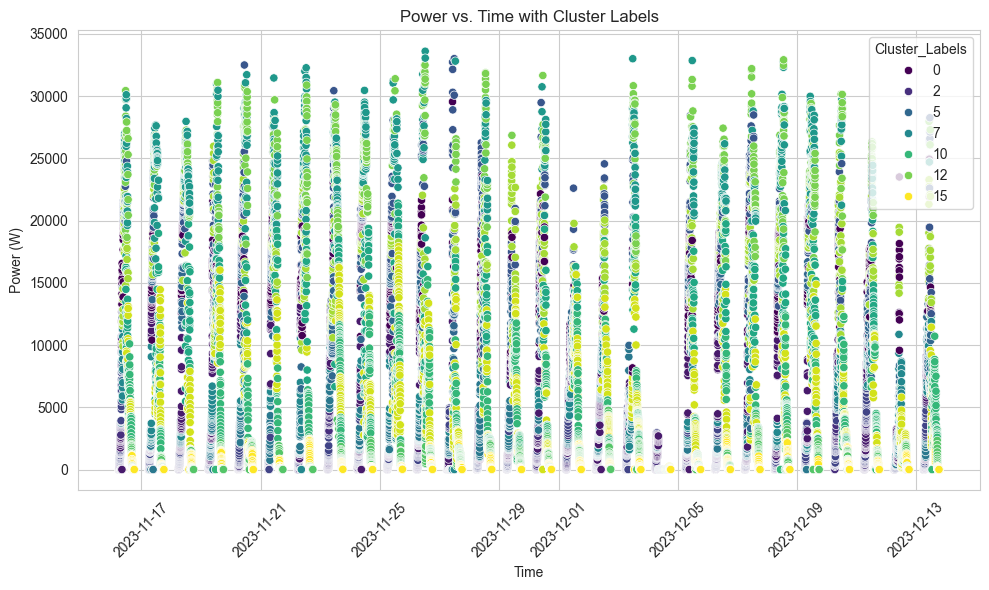

In [338]:
# Assuming your data is stored in a DataFrame called df

# Set the style
sns.set_style("whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_new, x="Time", y="Power(W)", hue="Cluster_Labels", palette="viridis")

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.title("Power vs. Time with Cluster Labels")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [355]:
df_new.to_csv('labled.csv', index=False)

In [356]:
# Save the SOM model to a file
joblib.dump(som, 'som_model.joblib')

['som_model.joblib']

In [15]:
# Load the trained SOM model
som = joblib.load('som_model.joblib')

In [350]:
new_data = [0,20.9,5,55]
# new_data = ['11.16.2023 14:40:34',5724,40.5]
# new_data[0] = pd.to_datetime(new_data[0], format='%m.%d.%Y %H:%M:%S')
# new_data[0] = round((new_data[0].timestamp() / 10**18),10)
# new_data = np.array(new_data).reshape(1,-1)

# new_data = scaler1.transform(new_data)

# print(new_data)

In [351]:
mapped_data_new = np.array([som.winner(d) for d in new_data])
cluster_labels_new = np.ravel_multi_index(mapped_data_new.T, (4, 4))
print(cluster_labels_new)

[10  8  8  8]


In [352]:
def find_bmu(input_data, som_model,scaler):
    # Ensure input_data is a 1D numpy array
    input_data = np.array(input_data).flatten()

    # Normalize the input data using the same scaler used for training
    normalized_input = scaler.transform(input_data.reshape(1, -1))

   # Normalize the weights of the SOM
    normalized_weights = som_model.get_weights() / np.linalg.norm(som_model.get_weights(), axis=-1, keepdims=True)

    # Calculate distances between normalized input_data and all neurons
    distances = np.linalg.norm(normalized_weights - normalized_input, axis=-1)
    # Find the index of the neuron with the smallest distance (BMU)
    bmu_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    return bmu_index

def predict_cluster(input_data, som_model,scaler):
    bmu_index = find_bmu(input_data, som_model,scaler)
    # Use the BMU index to determine the cluster
    predicted_cluster = assign_cluster_label(bmu_index ,som_model)
    return predicted_cluster

def visualize_som(input_data, som_model,scaler):
    bmu_index = find_bmu(input_data, som_model,scaler)

    # Visualize the SOM, highlighting the BMU
    plt.imshow(som_model.distance_map().T, cmap='bone_r', interpolation='none')
    plt.colorbar()

    # Highlight the BMU on the map
    plt.plot(bmu_index[0], bmu_index[1], 'rx', markersize=10, markeredgewidth=2)

    plt.show()

# Function to assign cluster labels (modify this based on your criteria)
def assign_cluster_label(bmu_index,som_model):
    # Example: You might use the coordinates of BMU as a label
    return bmu_index[0] * som_model._weights.shape[1] + bmu_index[1]


Predicted Cluster: 3
(0, 3)


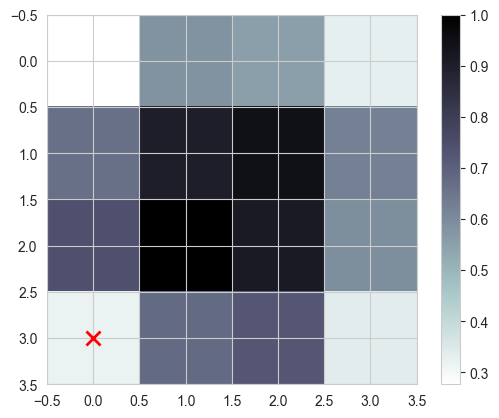

In [353]:
# Predict the cluster
predicted_cluster = predict_cluster(new_data, som,scaler1)
print(f"Predicted Cluster: {predicted_cluster}")
print(find_bmu(new_data, som,scaler1))

# Visualize the SOM with the BMU highlighted
visualize_som(new_data, som,scaler1)

In [354]:
# Save the SOM model to a file
joblib.dump(som, 'som_model.joblib')

['som_model.joblib']